In [1]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Define the colors and labels
RED = 1
BLUE = 0

maroon = (128, 0, 0)
violet = (128, 0, 128)

# Define the image size
SIZE = (1, 1)

# Generate 10 red images and 10 blue images
for i in range(10):
    # Generate a red image
    red_image = np.zeros((SIZE[0], SIZE[1], 3), dtype=np.uint8)
    red_image[:, :, 0] = 255  # Set red channel to max value
    red_image = Image.fromarray(red_image)
    red_image.save(f"red_{i}.png")
    # maroon_image = np.zeros((1, 1, 3), dtype=np.uint8)
    # maroon_image[0, 0, :] = maroon
    # maroon_image = Image.fromarray(maroon_image)
    # maroon_image.save(f"maroon_{i}.png")
    
    # Generate a blue image
    blue_image = np.zeros((SIZE[0], SIZE[1], 3), dtype=np.uint8)
    blue_image[:, :, 2] = 255  # Set blue channel to max value
    blue_image = Image.fromarray(blue_image)
    blue_image.save(f"blue_{i}.png")
    # violet_image = np.zeros((1, 1, 3), dtype=np.uint8)
    # violet_image[0, 0, :] = violet
    # violet_image = Image.fromarray(violet_image)
    # violet_image.save(f"violet_{i}.png")

# Define a custom dataset class
class ColorDataset(Dataset):
    def __init__(self):
        self.samples = []
        for i in range(10):
            # Load the red image
            image = Image.open(f"red_{i}.png")
            self.samples.append((transforms.ToTensor()(image), RED))
            
            # Load the blue image
            image = Image.open(f"blue_{i}.png")
            self.samples.append((transforms.ToTensor()(image), BLUE))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index]

# Create the dataset
dataset = ColorDataset()

# Use a data loader to iterate over the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Print the first few samples in the dataset
for i, (image, label) in enumerate(dataloader):
    print(f"Sample {i}: label = {label.item()}, color = {'red' if label.item() == 1 else 'blue'}")


Sample 0: label = 0, color = blue
Sample 1: label = 1, color = red
Sample 2: label = 1, color = red
Sample 3: label = 0, color = blue
Sample 4: label = 0, color = blue
Sample 5: label = 1, color = red
Sample 6: label = 0, color = blue
Sample 7: label = 0, color = blue
Sample 8: label = 1, color = red
Sample 9: label = 1, color = red
Sample 10: label = 0, color = blue
Sample 11: label = 1, color = red
Sample 12: label = 0, color = blue
Sample 13: label = 1, color = red
Sample 14: label = 0, color = blue
Sample 15: label = 1, color = red
Sample 16: label = 0, color = blue
Sample 17: label = 1, color = red
Sample 18: label = 0, color = blue
Sample 19: label = 1, color = red


In [2]:
print(dataset.__getitem__(1)[0].shape)

torch.Size([3, 1, 1])


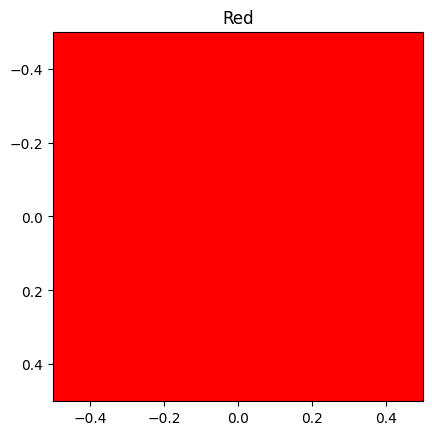

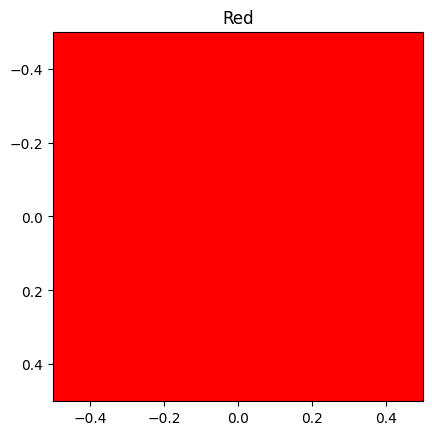

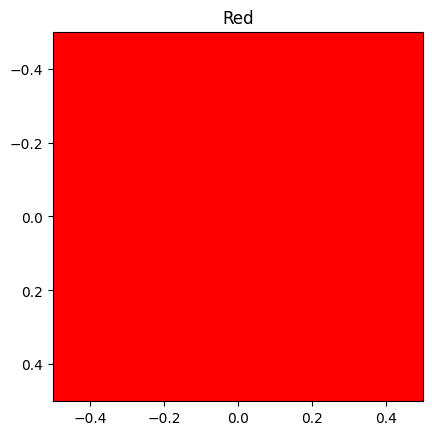

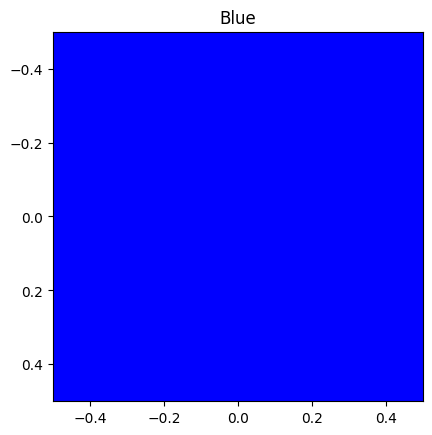

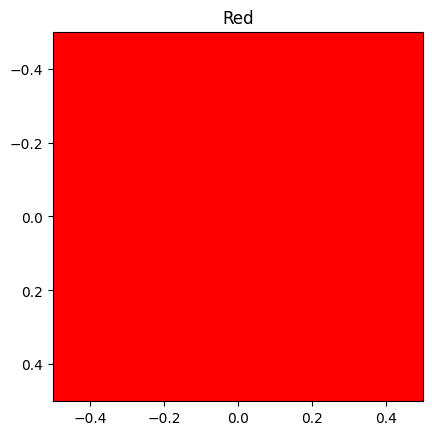

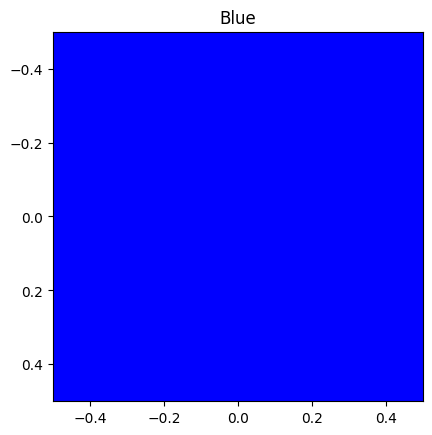

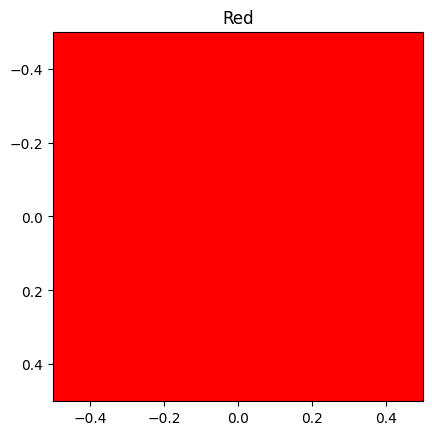

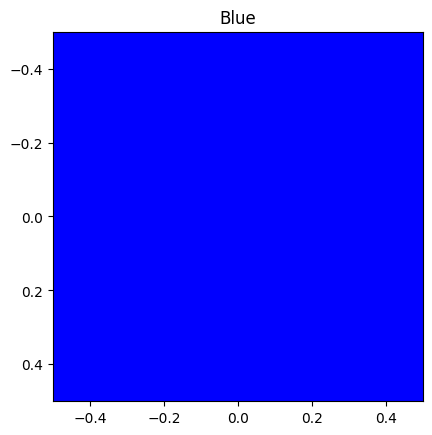

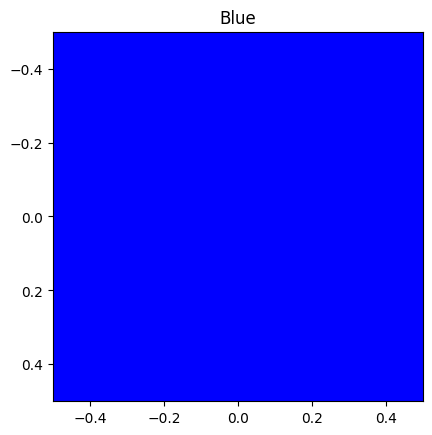

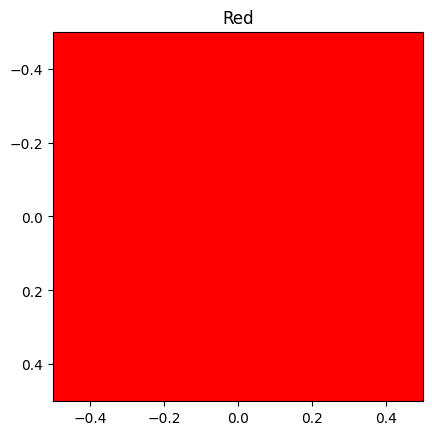

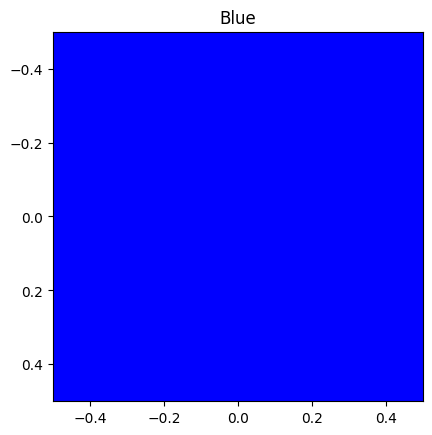

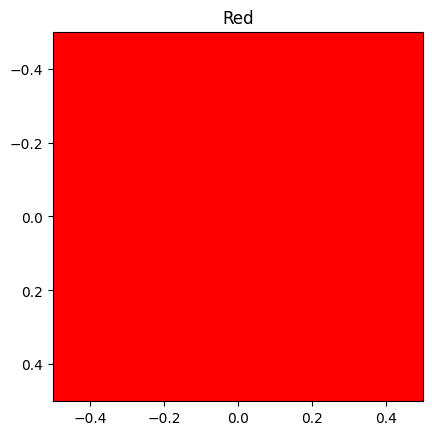

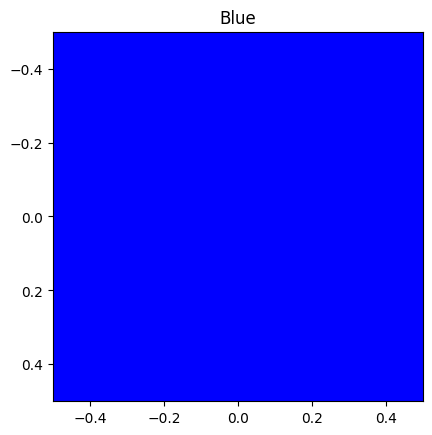

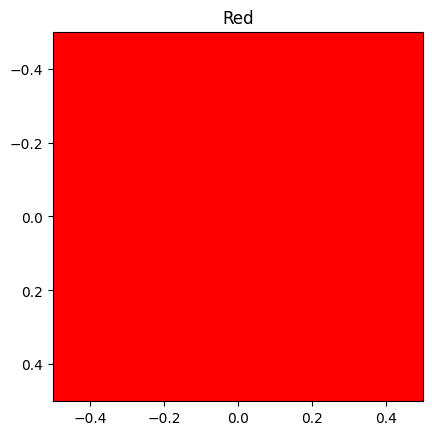

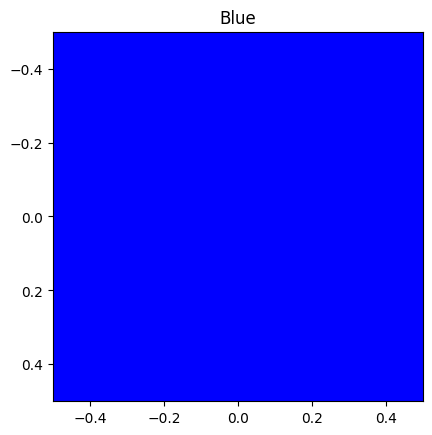

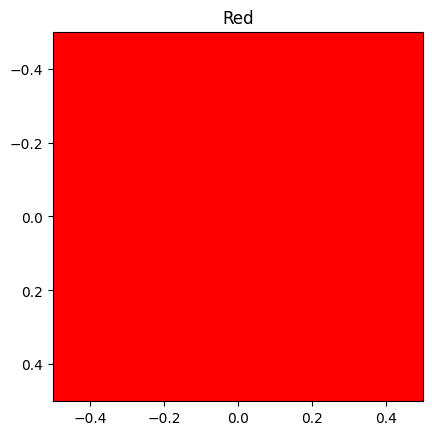

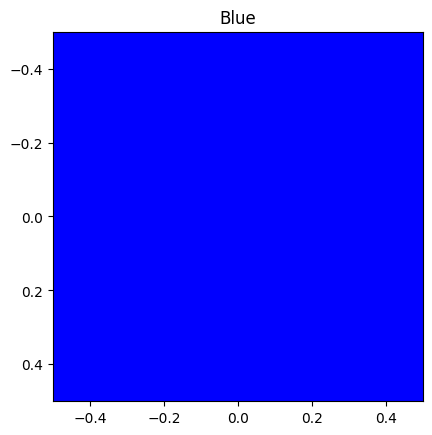

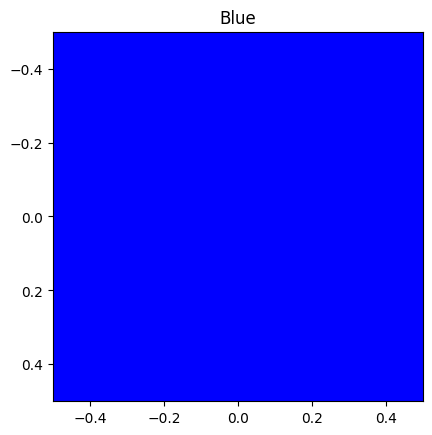

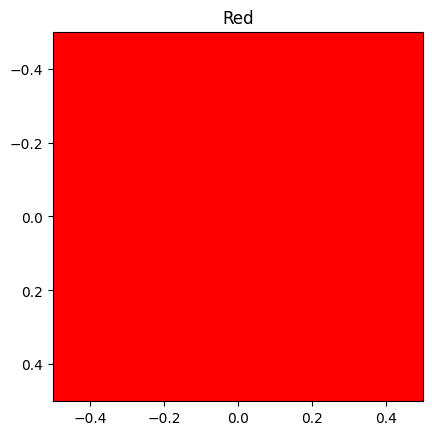

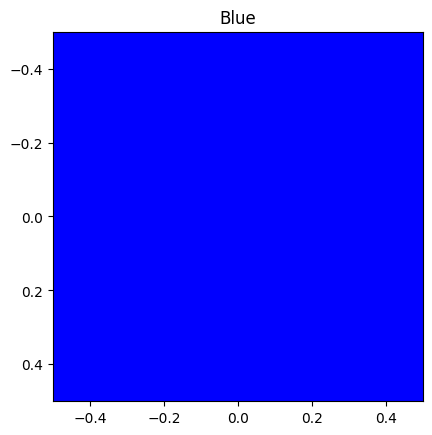

In [2]:
import matplotlib.pyplot as plt
for i, (image, label) in enumerate(dataloader):
    image = image.reshape(1,1,3)
    plt.imshow(image)
    plt.title("Red" if label.item() == 1 else "Blue")
    plt.show()

In [7]:
# Binary MLP model to assign classify them as 0 or 1
# Created the same model as depicted in the research papaer as 1000-1000-1

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ModifiedReluFunc(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.set_materialize_grads(False)
        ctx.x = x
        ctx.alpha = alpha
        return torch.relu(x)

    @staticmethod
    def backward(ctx, grad_output):
        if grad_output is None:
            return None, None
        return grad_output * ctx.x.mul(ctx.alpha).sigmoid(), None


class ModifiedRelu(nn.Module):
    def __init__(self, alpha):
        super(ModifiedRelu, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return ModifiedReluFunc.apply(x, self.alpha) 


## Creating a Binary MLP Model for MNIST Dataset
## Created model of 1000,1000 hidden layers

class BinaryMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.activation = ModifiedRelu(149.86555429083975)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dim, 1000)
        self.linear2 = nn.Linear(1000,1000,  bias = False)
        self.linear3 = nn.Linear(1000, output_dim  ,  bias = False)
        self.sigmoid = nn.Sigmoid()

     
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

# class BinaryMLP(nn.Module):
#     def __init__(self,alpha=0.1, beta=0.5):
#         super(BinaryMLP, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(3, 1000)
#         self.relu = nn.ReLU()
#         self.linear2 = nn.Linear(1000, 1000, bias = False)
#         self.linear3 = nn.Linear(1000, 1, bias = False)
#         self.sigmoid = nn.Sigmoid()
#         self.alpha = alpha
#         self.beta = beta

#     def forward(self, x):
#         x = self.flatten(x)
#         x = x.to(self.linear1.weight.dtype)
#         x = self.linear1(x)
#         x = self.relu(x) + self.alpha * torch.exp(self.beta * x) - self.alpha
#         x = self.linear2(x)
#         x = self.relu(x) + self.alpha * torch.exp(self.beta * x) - self.alpha
#         x = self.linear3(x)
#         x = self.sigmoid(x)
#         return x

# Create the model 
model = BinaryMLP(3,1).to(device)

optimizer = optim.Adam(model.parameters())

# Define the loss function
criterion = nn.BCELoss()

# Train the model
num_epochs = 10
batch_size = 2
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        data = data.reshape(2,1,1,3)
        data = data.to(device)
        outputs = model(data)
        outputs = outputs.to(device)
        targets = targets.to(device)
        print(outputs)
        print(targets)
        loss = criterion(outputs, targets.float().view(-1, 1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training status
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


tensor([[0.5362],
        [0.5362]], grad_fn=<SigmoidBackward0>)
tensor([0, 0])
Epoch [1/10], Batch [1/10], Loss: 0.7683
tensor([[0.2220],
        [0.2978]], grad_fn=<SigmoidBackward0>)
tensor([0, 1])
Epoch [1/10], Batch [2/10], Loss: 0.7312
tensor([[0.4043],
        [0.1454]], grad_fn=<SigmoidBackward0>)
tensor([1, 0])
Epoch [1/10], Batch [3/10], Loss: 0.5313
tensor([[0.5591],
        [0.1134]], grad_fn=<SigmoidBackward0>)
tensor([1, 0])
Epoch [1/10], Batch [4/10], Loss: 0.3509
tensor([[0.7070],
        [0.0937]], grad_fn=<SigmoidBackward0>)
tensor([1, 0])
Epoch [1/10], Batch [5/10], Loss: 0.2226
tensor([[0.0772],
        [0.8147]], grad_fn=<SigmoidBackward0>)
tensor([0, 1])
Epoch [1/10], Batch [6/10], Loss: 0.1426
tensor([[0.0612],
        [0.8843]], grad_fn=<SigmoidBackward0>)
tensor([0, 1])
Epoch [1/10], Batch [7/10], Loss: 0.0930
tensor([[0.9285],
        [0.0463]], grad_fn=<SigmoidBackward0>)
tensor([1, 0])
Epoch [1/10], Batch [8/10], Loss: 0.0608
tensor([[0.9562],
        [0.956

In [8]:
import torch
import torchvision
import os

loss_values = []
epoch_values = []

def range_loss(x):
    rangeLoss = 0
    rangeLoss += torch.pow(torch.where(x - 255 > 0, x - 255, torch.zeros_like(x)), 2).sum()
    rangeLoss += torch.pow(torch.where(0 - x > 0, 0 - x, torch.zeros_like(x)), 2).sum()
    return rangeLoss

def lambdaa_loss(l):
    lambdaaLoss = 0
    lambdaaLoss += 5 * torch.pow(torch.where(-l + 0.01 > 0, -l + 0.01, torch.zeros_like(l)), 2).sum()
    return lambdaaLoss    
    
def weight_loss(x, lambdaa, labels, model):
    
    model_output = model(x).squeeze()
    lambdaa = lambdaa.squeeze()
    
    lambdaa = lambdaa.to(device)
    model_output = model_output.to(device)
 
    secondPartOp = model_output * lambdaa * labels
    
    grad = torch.autograd.grad(
        outputs=secondPartOp,
        inputs=model.parameters(),
        grad_outputs=torch.ones_like(secondPartOp, requires_grad=False, device=secondPartOp.device).div(1000),
        create_graph=True,
        retain_graph=True,
    )
    
    weightLoss = 0

    for i, (p, grad) in enumerate(zip(model.parameters(), grad)):
        
        l = (p.detach().data - grad).pow(2).sum()
        
        weightLoss += l
        
    return weightLoss

def data_init(recons_data):
    c = 3 # Number of channels
    h = 1 # Dimension 1
    w = 1 # Dimension 2
    
    x = torch.randn(recons_data, c, h, w) 
    lambdaa = torch.rand(recons_data, 1) * -5
    
    x = x.to(device)
    lambdaa = lambdaa.to(device)
    
    x.requires_grad_(True)
    lambdaa.requires_grad_(True)
    
    labels = torch.zeros(recons_data).type(torch.get_default_dtype())
    labels = labels.to(device)
    
    labels[:labels.shape[0] // 2] = -1
    labels[labels.shape[0] // 2:] = 1
    labels = labels.long()
    
    return lambdaa, x , labels


def optimizers(lambdaa,x):
    x_optimizer = torch.optim.SGD([x], lr=1e-5, momentum=0.9)
    l_optimizer = torch.optim.SGD([lambdaa], lr=1e-4, momentum=0.9)
#     x_optimizer = torch.optim.Adam([x], lr=1e-5)
#     l_optimizer = torch.optim.Adam([lambdaa], lr=1e-4)
    return x_optimizer,l_optimizer
    
    
def reconstruction(model):
    recons_data = 100 # 50 for each class

    lambdaa , x , labels = data_init(recons_data)
    
    input_opt , lambdaa_opt = optimizers(lambdaa,x)

    num_of_epochs = 20001
    
    for epoch in range(num_of_epochs):

        weightLoss = weight_loss(x, lambdaa, labels, model)
        
        lambdaaLoss = lambdaa_loss(lambdaa)
        
        rangeLoss = range_loss(x)
        
        loss = lambdaaLoss + rangeLoss + weightLoss
            
        input_opt.zero_grad()
        lambdaa_opt.zero_grad()
        
        loss.backward()
        
        input_opt.step()
        lambdaa_opt.step()
        
        if(epoch < 1000):
            if(epoch%100 == 0):
                print("At Epoch ",epoch)
                print("Loss is ",loss)
                loss_values.append(loss)
                epoch_values.append(epoch)
                
        elif epoch%1000==0:
            print("At Epoch ",epoch)
            print("Loss is ",loss)
            torch.save(x, os.path.join(os.getcwd(), f'{epoch}_x1.pth'))
            loss_values.append(loss)
            epoch_values.append(epoch)
        
    return loss_values,epoch_values

In [9]:
model  = BinaryMLP(3,1).to(device)
loss_values, epoch_values = reconstruction(model)

At Epoch  0
Loss is  tensor(5315.5894, grad_fn=<AddBackward0>)
At Epoch  100
Loss is  tensor(1526.3804, grad_fn=<AddBackward0>)
At Epoch  200
Loss is  tensor(988.7339, grad_fn=<AddBackward0>)
At Epoch  300
Loss is  tensor(926.1020, grad_fn=<AddBackward0>)
At Epoch  400
Loss is  tensor(914.3597, grad_fn=<AddBackward0>)
At Epoch  500
Loss is  tensor(908.2457, grad_fn=<AddBackward0>)
At Epoch  600
Loss is  tensor(902.9231, grad_fn=<AddBackward0>)
At Epoch  700
Loss is  tensor(897.8684, grad_fn=<AddBackward0>)
At Epoch  800
Loss is  tensor(893.0186, grad_fn=<AddBackward0>)
At Epoch  900
Loss is  tensor(888.3599, grad_fn=<AddBackward0>)
At Epoch  1000
Loss is  tensor(883.8844, grad_fn=<AddBackward0>)
At Epoch  2000
Loss is  tensor(847.7438, grad_fn=<AddBackward0>)
At Epoch  3000
Loss is  tensor(823.5366, grad_fn=<AddBackward0>)
At Epoch  4000
Loss is  tensor(807.3224, grad_fn=<AddBackward0>)
At Epoch  5000
Loss is  tensor(796.4620, grad_fn=<AddBackward0>)
At Epoch  6000
Loss is  tensor(789.

In [12]:
losses = []
for loss in loss_values:
    losses.append(int(loss.data))

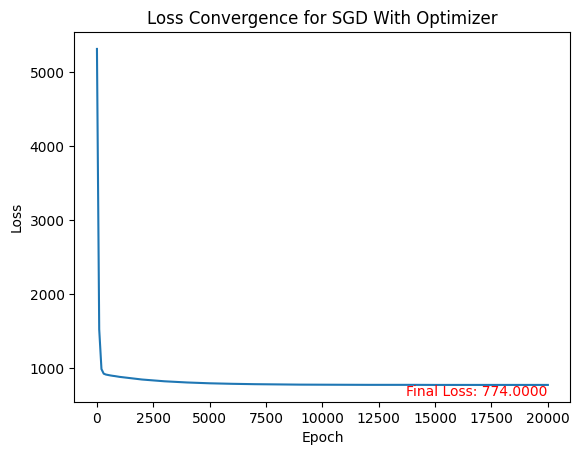

In [13]:
import matplotlib.pyplot as plt
plt.plot(epoch_values, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for SGD With Optimizer')

last_loss = losses[-1]
plt.text(epoch_values[-1], last_loss, f'Final Loss: {last_loss:.4f}', ha='right', va='top' , color='red')

plt.show()

In [15]:
x = torch.load("20000_x1.pth",map_location = device)
x = x.cpu()
x = x.detach().numpy()
x = x.reshape(100,1,1,3)

# y = y.detach().numpy()
# plt.imshow(x[67])
# plt.show()

In [16]:
images = dataset.samples
lst = []
for img,labels in images:
  img = img.detach().numpy()
  lst.append(img)

arr = np.array(lst)
print(arr.shape)

(20, 3, 1, 1)


In [17]:
y = arr
y = y.reshape(20,1,1,3)
print(y.shape)
print(x.shape)

(20, 1, 1, 3)
(100, 1, 1, 3)


In [18]:
import numpy as np

# Convert your 100 images to a numpy array of shape (100, 1, 1, 3)
# x = np.array(x).reshape(100, 1, 1, 3)

# Convert your 20 images to a numpy array of shape (20, 1, 1, 3)
# y = np.array(y).reshape(20, 1, 1, 3)

# Create a list to store the closest images
closest_images = []

# Iterate over each image in y
for i in range(len(y)):
    # Compute the distance between the current image in y and all images in x
    distances = np.sum(np.square(x - y[i]), axis=(1, 2, 3))
    
    # Firnd the index of the image in x that is closest to the current image in y
    closest_index = np.argmin(distances)
    
    # Add the closest image to the list and remove it from x
    closest_images.append(x[closest_index])
    x = np.delete(x, closest_index, axis=0)
    
# Convert the list of closest images to a numpy array
closest_images = np.array(closest_images)

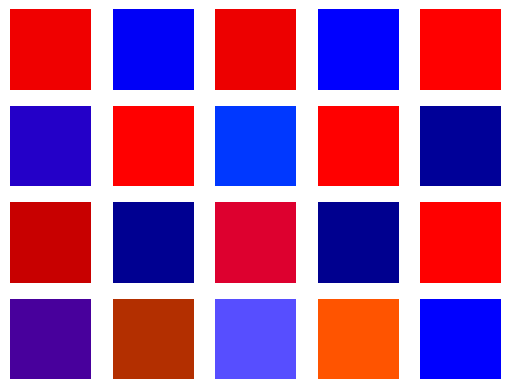

In [24]:
# for i in range(20):
#   plt.imshow(closest_images[i])
#   plt.show()
# Create a figure with a 4x5 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=5)

# Flatten the 4x5 grid of subplots into a 1D array
axes = axes.flatten()

# Loop through the closest_images array and display each image
for i, img in enumerate(closest_images):
    axes[i].imshow(img)
    axes[i].axis('off')

# Display the figure
plt.show()